In [1]:
import tensorflow as tf
from tensorflow import keras

from nn import datasets, models
from physics.hstar import gghzz, c6
from physics.hzz import zpair, angles
from physics.simulation import msq

import numpy as np
import matplotlib.pyplot as plt

import json, os

from sklearn.preprocessing import StandardScaler

2024-12-09 08:25:54.655338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 08:25:54.655369: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 08:25:54.655391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 08:25:54.661532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED=373485

JOBS_DIR='jobs/'
CONFIG_FILE=JOBS_DIR + 'train-SIG-10x2000-100k/job.config'

In [3]:
config=None
scaler_config=None

with open(CONFIG_FILE, 'r') as config_file:
    config, scaler_config  = json.loads(''.join(config_file.readlines()))

print(config)

{'sample_dir': '../..', 'output_dir': 'train-SIG-10x2000-100k', 'flags': ['sig'], 'learning_rate': 1e-05, 'batch_size': 32, 'num_events': 100000, 'num_layers': 10, 'num_nodes': 2000.0, 'epochs': 100, 'c6_values': [-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0]}


In [4]:
sample = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_sig.csv'), 200000))
sample.events = sample.events[120000:]

In [5]:
'''sample = gghzz.Process(  
    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 500000)
    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 350000),
    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 350000)
)

sample.events = sample.events[333333:]'''

"sample = gghzz.Process(  \n    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 500000)\n    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 350000),\n    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 350000)\n)\n\nsample.events = sample.events[333333:]"

In [6]:
def get_components(config):
    component_flag = np.array(config['flags'])[np.where(np.array(config['flags']) in ['sig', 'int', 'sig-vs-sbi', 'int-vs-sbi', 'bkg-vs-sbi'])]
    component_flag = component_flag[0] if component_flag.shape[0] != 0 else 'sbi'
    component_1, component_2 = component_flag.split('-')[0], component_flag.split('-')[-1]
    
    comp_dict = {'sig': msq.Component.SIG,
                 'int': msq.Component.INT,
                 'bkg': msq.Component.BKG,
                 'sbi': msq.Component.SBI}

    return (comp_dict[component_1], comp_dict[component_2])

In [7]:
z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')

sample.events.filter(msq.MSQFilter('msq_bkg_sm', value=0.0))
sample.events.filter(msq.MSQFilter('msq_bkg_sm', value=np.nan))
#sample.events.filter(angles.M4lFilter(m4l_min=250,m4l_max=300))
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

true_size = kin_variables.shape[0]

print(kin_variables.shape)

print(config['c6_values'], len(config['c6_values']))

if len(config['c6_values']) == 1:
    c6_values = np.array(config['c6_values']) 
else:
    c6_values = np.linspace(config['c6_values'][0], config['c6_values'][-1], 41)

component_1, component_2 = get_components(config)

if component_1 != msq.Component.BKG:
    c6_mod = c6.Modifier(baseline = component_1, c6_values = [-5,-1,0,1,5])
    c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)
else:
    c6_weights, c6_prob = np.array(sample[component_1].weights)[:,np.newaxis], np.array(sample[component_1].probabilities)[:,np.newaxis]

(78807, 8)
[-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0] 11


In [8]:
data = []

signal_weights = c6_prob
background_weights = tf.convert_to_tensor(sample[component_2].probabilities)[:,tf.newaxis]

for i in range(len(c6_values)):
    param = c6_values[i]

    sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
    bkg_weights = tf.cast(background_weights, tf.float32)

    print(sig_weights)
    print(bkg_weights)

    if len(c6_values)==1:
        data.append(tf.concat([kin_variables, sig_weights, bkg_weights], axis=1))
    else:
        data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

test_data = tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2]))

print(test_data)

2024-12-09 08:26:00.997816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 08:26:01.005752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 08:26:01.008340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

tf.Tensor(
[[1.09635357e-05]
 [7.00945520e-06]
 [6.41737279e-05]
 ...
 [1.49052385e-05]
 [1.66641239e-05]
 [1.50780043e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[8.7284143e-06]
 [6.1290821e-06]
 [5.2470830e-05]
 ...
 [1.2093205e-05]
 [2.3476237e-05]
 [1.2041132e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[1.1091973e-05]
 [7.2120520e-06]
 [6.3925814e-05]
 ...
 [1.5169983e-05]
 [1.5243157e-05]
 [1.5240214e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[8.7284143e-06]
 [6.1290821e-06]
 [5.2470830e-05]
 ...
 [1.2093205e-05]
 [2.3476237e-05]
 [1.2041132e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[1.1165378e-05]
 [7.3708220e-06]
 [6.3518659e-05]
 ...
 [1.5350617e-05]
 [1.4147547e-05]
 [1.5329069e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[8.7284143e-06]
 [6.1290821e-06]
 [5.2470830e-05]
 ...
 [1.2093205e-05]
 [2.3476237e-05]
 [1.2041132e-05]], shape=(78807, 1), dtype=float32)
tf.Tensor(
[[1.1183018e-05]
 [7.4828035e-06]
 [6.2965257e-05]
 ...
 [1.54443

In [9]:
scaler = StandardScaler()

print(test_data, test_data.shape)

scaler.mean_ = scaler_config['scaler.mean_']
scaler.var_ = scaler_config['scaler.var_']
scaler.scale_ = scaler_config['scaler.scale_']

test_data = tf.concat([scaler.transform(test_data[:,:-2]), test_data[:,-2:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:-2], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:-2], axis=0)

print('sigma (after):', sigma)

tf.Tensor(
[[ 7.85038888e-01  9.78138983e-01  9.99835730e-01 ... -2.00000000e+01
   1.09635357e-05  8.72841429e-06]
 [-6.87477589e-01  3.39282364e-01  8.69641721e-01 ... -2.00000000e+01
   7.00945520e-06  6.12908207e-06]
 [-9.91671801e-01  9.99973238e-01  9.99983191e-01 ... -2.00000000e+01
   6.41737279e-05  5.24708303e-05]
 ...
 [ 6.16930425e-01  9.38492358e-01  8.77629161e-01 ...  2.00000000e+01
   1.46651755e-05  1.20932054e-05]
 [-9.99167681e-01  9.99997139e-01  9.99654114e-01 ...  2.00000000e+01
   1.60327018e-05  2.34762374e-05]
 [-2.39338845e-01 -6.38202429e-01  8.96537602e-01 ...  2.00000000e+01
   1.48719328e-05  1.20411323e-05]], shape=(3231087, 11), dtype=float32) (3231087, 11)


2024-12-09 08:26:01.429277: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116319132 exceeds 10% of free system memory.


tf.Tensor(
[[ 9.81881499e-01  5.21092713e-01  5.65466285e-01 ... -1.58113885e+00
   1.09635357e-05  8.72841429e-06]
 [-8.79515827e-01 -6.74602032e-01  3.23437244e-01 ... -1.58113885e+00
   7.00945520e-06  6.12908207e-06]
 [-1.26404548e+00  5.61958075e-01  5.65740407e-01 ... -1.58113885e+00
   6.41737279e-05  5.24708303e-05]
 ...
 [ 7.69376814e-01  4.46889430e-01  3.38285804e-01 ...  1.58113885e+00
   1.46651755e-05  1.20932054e-05]
 [-1.27352095e+00  5.62002778e-01  5.65128684e-01 ...  1.58113885e+00
   1.60327018e-05  2.34762374e-05]
 [-3.13026905e-01 -2.50407887e+00  3.73436362e-01 ...  1.58113885e+00
   1.48719328e-05  1.20411323e-05]], shape=(3231087, 11), dtype=float32) (3231087, 11)
Mean (after): tf.Tensor(
[-2.1735619e-05 -6.5461174e-03  1.0234151e-02 -2.9761663e-03
 -2.5525175e-03 -4.6974220e-03  4.5715952e-03  2.2759889e-03
  1.1560665e-08], shape=(9,), dtype=float32)
sigma (after): tf.Tensor(
[0.9978979  1.0060791  0.987659   1.000033   0.9979757  0.9903624
 1.0046088  1.0015

2024-12-09 08:26:01.794718: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116319132 exceeds 10% of free system memory.
2024-12-09 08:26:01.889925: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142167828 exceeds 10% of free system memory.


In [10]:
model = keras.models.load_model(os.path.join(JOBS_DIR, config['output_dir'], 'checkpoint.model.tf'), custom_objects={'C6_4l_clf': models.C6_4l_clf, 'swish_activation': models.swish_activation})

In [11]:
data = test_data[:,:8][:,np.newaxis]

print(data)
predictions = model.predict(data, verbose=1)

real_ratios = test_data[:,8]/test_data[:,9]

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

2024-12-09 08:26:02.804305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103394784 exceeds 10% of free system memory.


tf.Tensor(
[[[ 0.9818815   0.5210927   0.5654663  ...  0.47072288  0.4366265
    0.4198285 ]]

 [[-0.8795158  -0.67460203  0.32343724 ... -1.4159607  -1.6869972
    2.6291597 ]]

 [[-1.2640455   0.5619581   0.5657404  ...  0.1498084   0.13081278
   -0.29326755]]

 ...

 [[ 0.7693768   0.44688943  0.3382858  ...  0.28166765  0.21074452
    0.9170301 ]]

 [[-1.273521    0.5620028   0.5651287  ... -2.7177122   0.43165952
   -1.0458145 ]]

 [[-0.3130269  -2.5040789   0.37343636 ... -0.10199273  0.09486847
    0.34947062]]], shape=(3231087, 1, 8), dtype=float32)


ValueError: in user code:

    File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filesd3xgllw.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).custom_layers[0], (ag__.ld(inputs),), None, fscope)

    ValueError: Exception encountered when calling layer 'c6_4l_clf' (type C6_4l_clf).
    
    in user code:
    
        File "/home/max/git/ggZZ_work/higgs-offshell-interpretation/nn/models.py", line 37, in call  *
            x = self.custom_layers[0](inputs)
        File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/max/git/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 1, 8)
    
    
    Call arguments received by layer 'c6_4l_clf' (type C6_4l_clf):
      • inputs=tf.Tensor(shape=(None, 1, 8), dtype=float32)


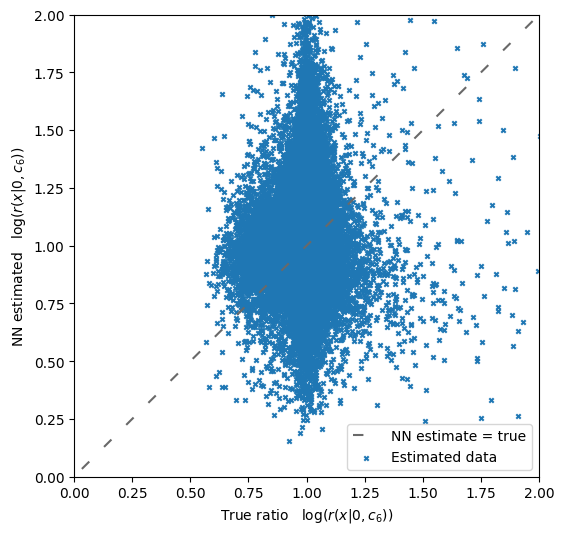

In [ ]:
lnspc = np.linspace(-3.0,2.5)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data')
plt.xlabel(u'True ratio   log$(r(x|0,c_6))$')#$P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   log$(r(x|0,c_6))$')#$P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

plt.show()

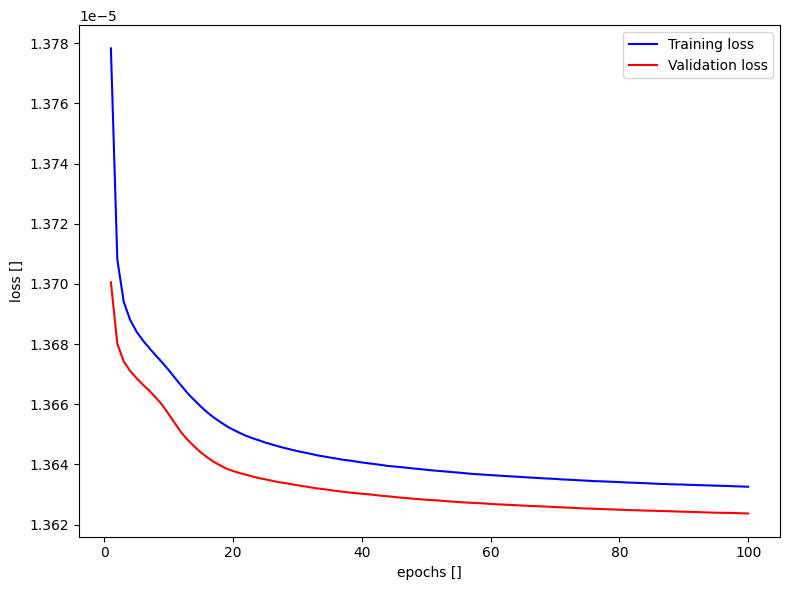

In [ ]:
hist_prm = ''

with open(os.path.join(JOBS_DIR, config['output_dir'], 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [56]:
rndint = np.random.choice(np.arange(0,true_size)).astype(int)

print(rndint)

data = test_data[rndint::true_size,:9][:,np.newaxis]

print(data.shape)

pred = model.predict(data, verbose=2)

real_ratios = test_data[rndint::true_size,9]/test_data[rndint::true_size,10]

pred = tf.convert_to_tensor(pred)

ratios = tf.squeeze(pred/(1-pred), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

max_val = max(tf.math.reduce_max(real_ratios).numpy(), tf.math.reduce_max(ratios).numpy())

real = real_ratios.numpy()
pred = ratios.numpy()

print(real.shape)
print(pred.shape)

50154
(41, 1, 9)
2/2 - 0s - 27ms/epoch - 13ms/step
tf.Tensor(
[[1.0773077 ]
 [1.051109  ]
 [1.0255601 ]
 [1.0019584 ]
 [0.9813896 ]
 [0.96458113]
 [0.951809  ]
 [0.9429059 ]
 [0.937411  ]
 [0.9347906 ]
 [0.9346253 ]
 [0.936658  ]
 [0.94070864]
 [0.94654936]
 [0.9538253 ]
 [0.9620658 ]
 [0.970745  ]
 [0.97935796]
 [0.9874751 ]
 [0.994768  ]
 [1.0010138 ]
 [1.0060824 ]
 [1.0099229 ]
 [1.0125543 ]
 [1.0140599 ]
 [1.0145867 ]
 [1.0143467 ]
 [1.0136163 ]
 [1.0127257 ]
 [1.0120366 ]
 [1.0119084 ]
 [1.0126567 ]
 [1.0145131 ]
 [1.0176064 ]
 [1.0219569 ]
 [1.0274988 ]
 [1.0341084 ]
 [1.0416214 ]
 [1.0498439 ]
 [1.0585468 ]
 [1.0674586 ]], shape=(41, 1), dtype=float32) tf.Tensor(0.9346253, shape=(), dtype=float32) tf.Tensor(1.0773077, shape=(), dtype=float32)
tf.Tensor(
[1.0312955  1.001633   0.97563905 0.9538718  0.9366613  0.9240901
 0.9160048  0.9120536  0.9117382  0.9144729  0.919638   0.9266246
 0.93486667 0.9438602  0.9531723  0.9624432  0.9713815  0.97975844
 0.9873993  0.994176   1.     

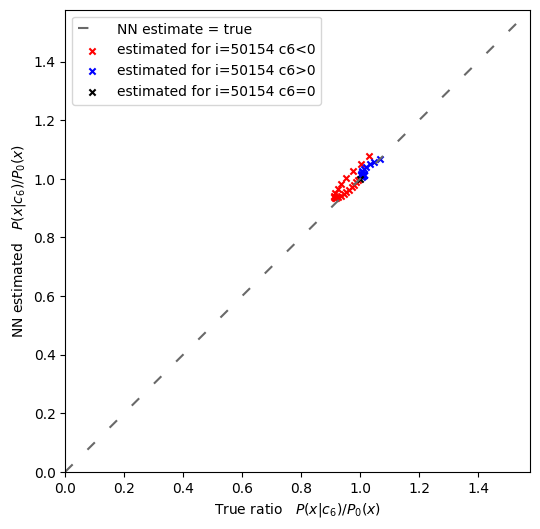

In [57]:
lnspc = np.linspace(0.0,max_val + 0.5)

plt.figure(figsize=(6,6))

c6_0 = int((len(c6_values)-1)/2)

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real[:c6_0], pred[:c6_0], color='r', s=20, marker='x', label=f'estimated for i={rndint} c6<0')
plt.scatter(real[c6_0+1:], pred[c6_0+1:], color='b', s=20, marker='x', label=f'estimated for i={rndint} c6>0')
plt.scatter(real[c6_0], pred[c6_0], color='k', s=20, marker='x', label=f'estimated for i={rndint} c6=0')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,max_val + 0.5)
plt.ylim(0.0,max_val + 0.5)
plt.legend()
#19
plt.show()

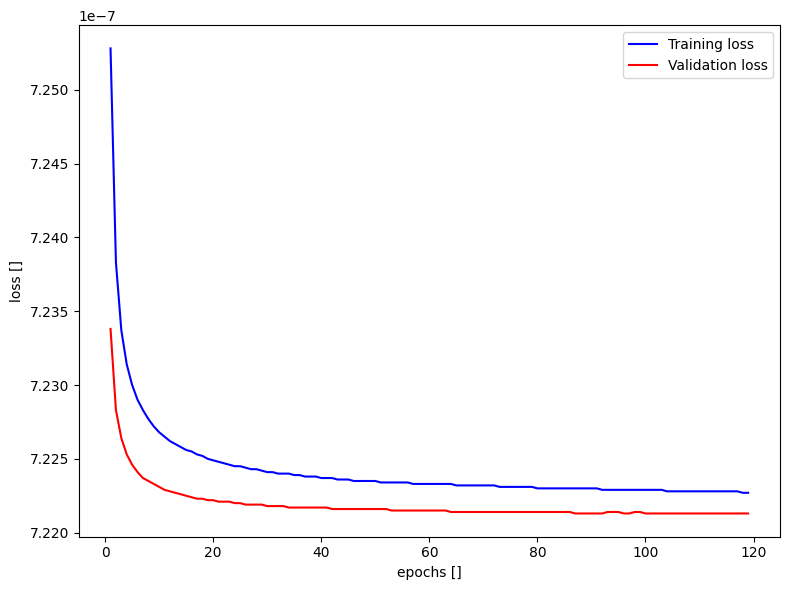

In [ ]:
JOB_ID = 13876921
JOB_OUT_FILE = os.path.join(JOBS_DIR, config['output_dir'], 'logs', 'job.out.' + str(JOB_ID))

import re

with open(JOB_OUT_FILE, 'r') as log_file:
    logs = ''.join(log_file.readlines())

t_loss = np.array(re.findall("\ loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)
v_loss = np.array(re.findall("\ val_loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)

epochs = range(1,t_loss.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [30]:
data = test_data[:,:-2]

c6_val = 20
c6_scaled = (c6_val-scaler.mean_[8])/scaler.scale_[8]

data = tf.gather(data,tf.where(data[:,-1]==c6_scaled))
data = tf.reshape(data, shape=(data.shape[0], data.shape[1]*data.shape[2]))

print(data)
predictions = model.predict(data, verbose=1)

test_data_at_c6 = tf.gather(test_data,tf.where(test_data[:,-3]==c6_scaled))
test_data_at_c6 = tf.reshape(test_data_at_c6, shape=(test_data_at_c6.shape[0], test_data_at_c6.shape[1]*test_data_at_c6.shape[2]))
print(test_data_at_c6)

real_ratios = test_data_at_c6[:,-2]/test_data_at_c6[:,-1]

predictions = tf.convert_to_tensor(predictions)

ratios = predictions/(1-predictions)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

tf.Tensor(
[[ 0.9818815   0.5210927   0.5654663  ...  0.4366265   0.4198285
   1.5811388 ]
 [-0.8795158  -0.67460203  0.32343724 ... -1.6869972   2.6291597
   1.5811388 ]
 [-1.2640455   0.5619581   0.5657404  ...  0.13081278 -0.29326755
   1.5811388 ]
 ...
 [ 0.7693768   0.44688943  0.3382858  ...  0.21074452  0.9170301
   1.5811388 ]
 [-1.273521    0.5620028   0.5651287  ...  0.43165952 -1.0458145
   1.5811388 ]
 [-0.3130269  -2.5040789   0.37343636 ...  0.09486847  0.34947062
   1.5811388 ]], shape=(78807, 9), dtype=float32)
2463/2463 [==============================] - 5s 2ms/step
tf.Tensor(
[[ 9.81881499e-01  5.21092713e-01  5.65466285e-01 ...  1.58113885e+00
   1.07110745e-05  8.72841429e-06]
 [-8.79515827e-01 -6.74602032e-01  3.23437244e-01 ...  1.58113885e+00
   7.00645296e-06  6.12908207e-06]
 [-1.26404548e+00  5.61958075e-01  5.65740407e-01 ...  1.58113885e+00
   6.32423908e-05  5.24708303e-05]
 ...
 [ 7.69376814e-01  4.46889430e-01  3.38285804e-01 ...  1.58113885e+00
   1.4665

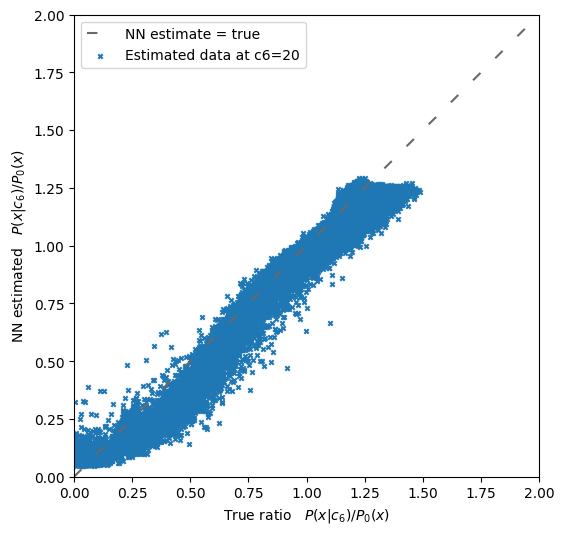

In [31]:
lnspc = np.linspace(0.0,2.0)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data at c6={c6_val}')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

plt.show()